In [1]:
import time

import os
import cv2
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Levenshtein import ratio
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Reshape, LSTM, Conv2D, BatchNormalization, LeakyReLU, Dropout, MaxPooling2D, concatenate
from keras.models import Model
from keras.optimizers import Nadam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.backend import get_value, ctc_decode

2024-05-19 02:24:40.268564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 02:24:40.334351: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 02:24:40.641585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ibolkisev/anaconda3/envs/tf/lib/python3.10/site-packages/cv2/../../lib64::/lib/:/home/ibolki

In [2]:
cd ../handwritten_data/

/home/ibolkisev/handwritten_data


In [3]:
import pandas as pd
train = pd.read_csv('./train.tsv', sep='\t', header=None)
train

,0,1
0,aa1.png,Молдова
1,aa1007.png,продолжила борьбу
2,aa101.png,разработанные
3,aa1012.png,Плачи
4,aa1013.png,Гимны богам
...,...,...
73825,testtt658.png,г. Иркутска
73826,testtt659.png,"Андреевна,"
73827,testtt677.png,Юрьевна
73828,testtt692.png,девяносто)


In [4]:
X, y = [], []
for fn, label in train.values:
    img = cv2.imread('./train/' + fn)[:, :, ::-1]
    if img is None or label is None:
        continue
    X.append(img)
    y.append(str(label).upper())

libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng warning: cHRM: invalid chromaticities
libpng war

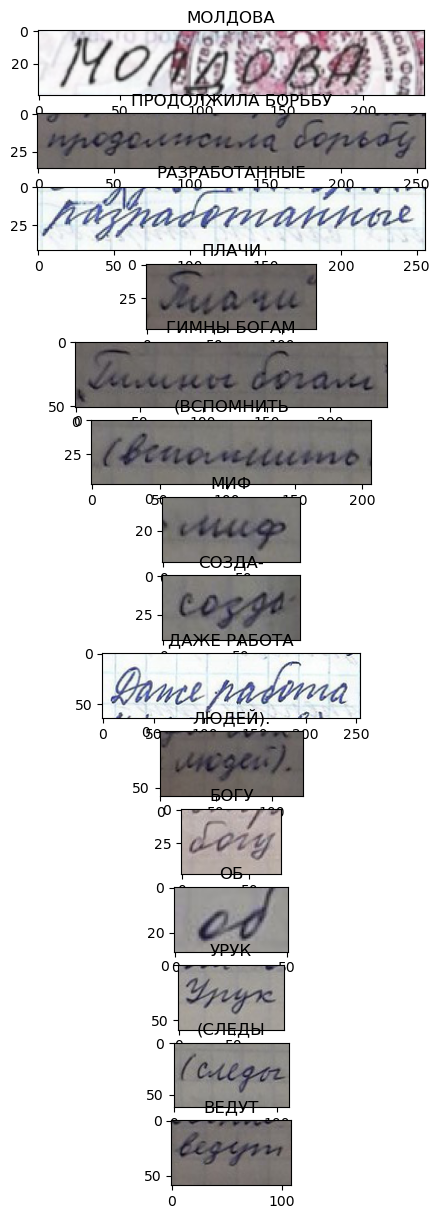

In [5]:
fig, axes = plt.subplots(nrows=15, figsize=(5, 15))

for i in range(15):
    axes[i].imshow(X[i], cmap='gray')
    axes[i].set_title(y[i])

In [6]:
def preprocess(X, shape=(32, 400)):
    for i in range(len(X)):
        img = X[i][:, :, 0]
        scale = min(shape[0] / img.shape[0], shape[1] / img.shape[1])
        img = cv2.resize(img, None, fx=scale, fy=scale, interpolation = cv2.INTER_AREA)
        print(np.floor((shape[0] - img.shape[0]) / 2).astype(int),
                                         np.ceil((shape[0] - img.shape[0]) / 2).astype(int),
                                         shape[1] - img.shape[1],
                                         0)
        img = cv2.copyMakeBorder(img,
                                         np.floor((shape[0] - img.shape[0]) / 2).astype(int),
                                         np.ceil((shape[0] - img.shape[0]) / 2).astype(int),
                                         0,
                                         shape[1] - img.shape[1],
                                         cv2.BORDER_CONSTANT, value=255)
        X[i] = img
    return np.array(X)

X = preprocess(X)
X.shape

0 0 210 0
0 0 172 0
0 0 205 0
0 0 316 0
0 0 246 0
0 0 262 0
0 0 332 0
0 0 332 0
0 0 273 0
0 0 329 0
0 0 351 0
0 0 344 0
0 0 348 0
0 0 343 0
0 0 341 0
0 0 337 0
0 0 272 0
0 0 332 0
0 0 273 0
0 0 348 0
0 0 307 0
0 0 328 0
0 0 202 0
0 0 229 0
0 0 317 0
0 0 302 0
0 0 231 0
0 0 347 0
0 0 287 0
0 0 325 0
0 0 333 0
0 0 250 0
0 0 261 0
0 0 289 0
0 0 316 0
0 0 255 0
0 0 254 0
0 0 366 0
0 0 324 0
0 0 331 0
0 0 323 0
0 0 222 0
0 0 267 0
0 0 223 0
0 0 352 0
0 0 271 0
0 0 315 0
0 0 302 0
0 0 301 0
0 0 309 0
0 0 357 0
0 0 213 0
0 0 282 0
0 0 353 0
0 0 297 0
0 0 286 0
0 0 352 0
0 0 242 0
0 0 336 0
0 0 364 0
0 0 321 0
0 0 291 0
0 0 332 0
0 0 327 0
0 0 248 0
0 0 317 0
0 0 360 0
0 0 350 0
0 0 296 0
0 0 357 0
0 0 317 0
0 0 349 0
0 0 261 0
0 0 296 0
0 0 357 0
0 0 201 0
0 0 243 0
0 0 298 0
0 0 334 0
0 0 345 0
0 0 323 0
0 0 295 0
0 0 324 0
0 0 298 0
0 0 308 0
0 0 344 0
0 0 366 0
0 0 335 0
0 0 205 0
0 0 302 0
0 0 275 0
0 0 278 0
0 0 334 0
0 0 237 0
0 0 287 0
0 0 369 0
0 0 336 0
0 0 273 0
0 0 331 0
0 0 341 0


(73830, 32, 400)

In [7]:
def encode_texts(texts):
    def _label_to_num(label, alphabet):
        label_num = []
        for ch in label:
            label_num.append(alphabet.find(ch))
        return np.array(label_num)
    
    alphabet = ''.join(sorted(pd.Series(texts).apply(list).apply(pd.Series).stack().unique()))
    
    nums = np.ones([len(texts), max([len(text) for text in texts])], dtype='int64') * len(alphabet)
    for i, text in enumerate(texts):
        nums[i][:len(text)] = _label_to_num(text, alphabet)
    
    return nums, alphabet

In [8]:
labels_encoded, alphabet = encode_texts(y)
alphabet

' !"%\'()+,-./0123456789:;=?ABCEHINOPRSTUXY[]«»ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ№'

In [9]:
X = X.astype('float32') / 255

In [10]:
train_X, val_X, train_y, val_y = train_test_split(X, labels_encoded, random_state=42)
train_X.shape, train_y.shape, val_X.shape, val_y.shape

((55372, 32, 400), (55372, 40), (18458, 32, 400), (18458, 40))

In [11]:
class CER(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER', decode_greedy=True, **kwargs):
        super(CER, self).__init__(name=name, **kwargs)
        self.decode_greedy = decode_greedy
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = K.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * K.cast(input_shape[1], 'float32')

        decode, log = K.ctc_decode(y_pred, input_length, greedy=True)

        decode = K.ctc_label_dense_to_sparse(decode[0], K.cast(input_length, 'int32'))
        y_true_sparse = K.ctc_label_dense_to_sparse(y_true, K.cast(input_length, 'int32'))
        y_true_sparse = tf.sparse.retain(y_true_sparse, tf.not_equal(y_true_sparse.values, tf.math.reduce_max(y_true_sparse.values)))

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(K.cast(len(y_true), 'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)


def CTCLoss(y_true, y_pred):
    """
    Compute the training-time loss value
    """
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [12]:
def Conv_2D_Block(x, model_width, kernel, strides=(1, 1), padding="same"):
    # 2D Convolutional Block with BatchNormalization
    x = Conv2D(model_width, kernel, strides=strides, padding=padding, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)
    return x


def inception_module(layer_in, filter, concat_filter):
    # 1x1 conv
    conv1 = Conv_2D_Block(layer_in, filter, (1,1))
    # 3x3 conv
    conv3 = Conv_2D_Block(layer_in, filter * 4, (3,3))
    conv3 = Conv_2D_Block(conv3, filter, (1,1))
    # 5x5 conv
    conv5 = Conv_2D_Block(layer_in, filter * 4, (5,5))
    conv5 = Conv_2D_Block(conv5, filter, (1,1))
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)

    x = concatenate([conv1, conv3, conv5, pool], axis=-1)
    x = Conv2D(concat_filter, (1, 1), activation='linear', strides=(1, 1), kernel_initializer="he_normal")(x)
    x = LeakyReLU()(x)
    out = Dropout(0.2)(x)

    return out

In [13]:
input = Input(shape=(32, 400, 1)) 

x = inception_module(input, 16, 32)
x = MaxPooling2D((2, 2))(x)

x = inception_module(x, 32, 64)
x = MaxPooling2D((2, 1))(x)

x = inception_module(x, 32, 64)
x = MaxPooling2D((2, 2))(x)

x = inception_module(x, 64, 128)
x = MaxPooling2D((2, 2))(x)

x = inception_module(x, 128, 256)
x = MaxPooling2D((2, 1))(x)

x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)

x = Reshape((50, 64))(x)

x = LSTM(256, return_sequences=True)(x)
x = LSTM(256, return_sequences=True)(x)

x = Dense(len(alphabet) + 1, activation='softmax')(x)

model = Model(inputs=input, outputs=x)

model.compile(optimizer=Nadam(learning_rate=0.0005), loss=CTCLoss, metrics=[CER()])
model.summary()

2024-05-19 02:25:18.131502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 02:25:18.131615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 02:25:18.149350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 02:25:18.149489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-19 02:25:18.149560: I tensorflow/compiler/xla/stream_executo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 400, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 400, 64)  640         ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 400, 64)  1664        ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 400, 64)  256        ['conv2d_1[0][0]']           

In [14]:
class ReduceLRBacktrack(ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                             self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best): # not new best
            if not self.in_cooldown(): # and we're not in cooldown
                if self.wait+1 >= self.patience: # going to reduce lr
                    # load best model so far
                    print("Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs) # actually reduce LR

In [16]:
checkpoint_filepath = './best.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(train_X, train_y, validation_data=(val_X, val_y),
                    epochs=1000, batch_size=32,
                    callbacks=[model_checkpoint_callback, 
                               ReduceLRBacktrack(checkpoint_filepath, factor=0.5, min_lr=1e-5, patience=10),
                               EarlyStopping(patience=25, restore_best_weights=True)], 
                    verbose=1)

Epoch 1/1000
1731/1731 [==============================] - 271s 157ms/step - loss: 21.0225 - CER: 0.8090 - val_loss: 18.9872 - val_CER: 0.7315 - lr: 0.0010
Epoch 2/1000
1731/1731 [==============================] - 272s 157ms/step - loss: 17.0687 - CER: 0.6467 - val_loss: 14.7265 - val_CER: 0.5528 - lr: 0.0010
Epoch 3/1000
1731/1731 [==============================] - 271s 156ms/step - loss: 14.1209 - CER: 0.5255 - val_loss: 12.4665 - val_CER: 0.4614 - lr: 0.0010
Epoch 4/1000
1731/1731 [==============================] - 271s 156ms/step - loss: 12.4780 - CER: 0.4593 - val_loss: 11.3157 - val_CER: 0.4181 - lr: 0.0010
Epoch 5/1000
1731/1731 [==============================] - 271s 157ms/step - loss: 11.3261 - CER: 0.4136 - val_loss: 10.1493 - val_CER: 0.3656 - lr: 0.0010
Epoch 6/1000
1731/1731 [==============================] - 271s 157ms/step - loss: 10.7601 - CER: 0.3917 - val_loss: 9.4012 - val_CER: 0.3410 - lr: 0.0010
Epoch 7/1000
1731/1731 [==============================] - 271s 157ms/st

KeyboardInterrupt: 

In [15]:
model.load_weights('./best.h5')

In [16]:
checkpoint_filepath = './best.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(train_X, train_y, validation_data=(val_X, val_y),
                    epochs=1000, batch_size=32,
                    callbacks=[model_checkpoint_callback, 
                               ReduceLRBacktrack(checkpoint_filepath, factor=0.5, min_lr=1e-5, patience=4),
                               EarlyStopping(patience=10, restore_best_weights=True)], 
                    verbose=1)

Epoch 1/1000


2024-05-19 02:25:24.889556: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-19 02:25:26.208660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2024-05-19 02:25:26.209079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-19 02:25:28.263136: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-19 02:25:28.263166: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate

1731/1731 [==============================] - ETA: 0s - loss: 8.0400 - CER: 0.2921

2024-05-19 02:29:42.148756: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-19 02:29:42.148781: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-19 02:29:42.333448: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-19 02:29:42.333469: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

1731/1731 [==============================] - 284s 159ms/step - loss: 8.0400 - CER: 0.2921 - val_loss: 7.3039 - val_CER: 0.2620 - lr: 5.0000e-04
Epoch 2/1000
1731/1731 [==============================] - 270s 156ms/step - loss: 7.8370 - CER: 0.2868 - val_loss: 7.1095 - val_CER: 0.2529 - lr: 5.0000e-04
Epoch 3/1000
1731/1731 [==============================] - 270s 156ms/step - loss: 7.7273 - CER: 0.2806 - val_loss: 7.3771 - val_CER: 0.2595 - lr: 5.0000e-04
Epoch 4/1000
1731/1731 [==============================] - 271s 156ms/step - loss: 7.5982 - CER: 0.2777 - val_loss: 6.8934 - val_CER: 0.2472 - lr: 5.0000e-04
Epoch 5/1000
1731/1731 [==============================] - 270s 156ms/step - loss: 7.5208 - CER: 0.2748 - val_loss: 7.2111 - val_CER: 0.2520 - lr: 5.0000e-04
Epoch 6/1000
1731/1731 [==============================] - 271s 156ms/step - loss: 7.4649 - CER: 0.2726 - val_loss: 7.0865 - val_CER: 0.2502 - lr: 5.0000e-04
Epoch 7/1000
1731/1731 [==============================] - 270s 156ms/st

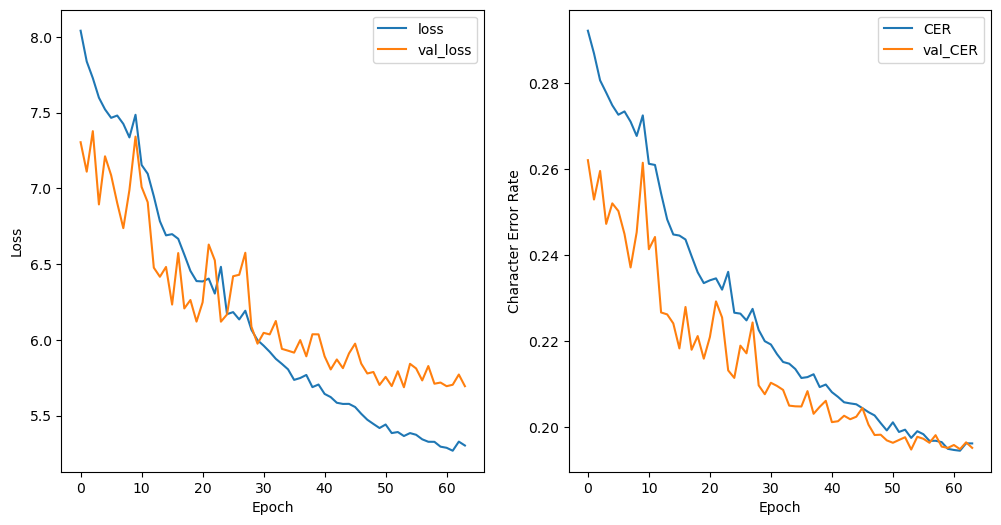

In [18]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[1].plot(history.history['CER'], label='CER')
axes[1].plot(history.history['val_CER'], label='val_CER')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Character Error Rate")
axes[1].legend()

plt.show()

In [19]:
def num_to_label(num, alphabet):
    text = ""
    for ch in num:
        if ch == len(alphabet): # ctc blank
          break
        else:
          text += alphabet[ch]
    return text


# Decode labels for softmax matrix
def decode_texts(nums, alphabet, greedy):
    values = get_value(ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1], 
                                  greedy=greedy)[0][0])

    texts = []
    for i in range(nums.shape[0]):
        value = values[i]
        texts.append(num_to_label(value[value >= 0], alphabet))
    return texts

In [20]:
pred_y = model.predict(val_X)

577/577 [==============================] - 19s 31ms/step


In [22]:
start = time.time()
pred_y_decoded_greedy = decode_texts(pred_y, alphabet, True)
print(time.time() - start)

0.17749381065368652


In [23]:
val_y_decoded = [num_to_label(gt, alphabet) for gt in val_y]

mean_greedy_lratio = sum(ratio(pred, gt) for pred, gt in zip(pred_y_decoded_greedy, val_y_decoded)) / len(val_y_decoded)

print(mean_greedy_lratio)

0.8340395553401111


<Axes: xlabel='lenght'>

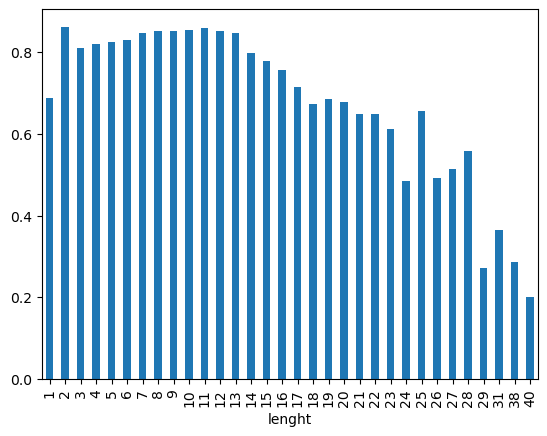

In [24]:
ratios = [ratio(pred, gt) for pred, gt in zip(pred_y_decoded_greedy, val_y_decoded)]
lenghts = [len(gt) for gt in val_y_decoded]

df = pd.DataFrame.from_dict({'lratio': ratios, 'lenght': lenghts})

df.groupby('lenght').lratio.mean().plot.bar()

1/1 [==============================] - 0s 14ms/step


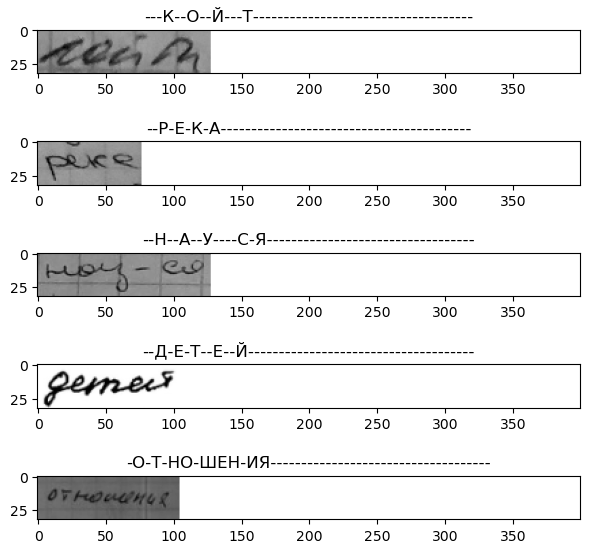

In [27]:
fig, axes = plt.subplots(nrows=5, figsize=(7, 7))


for i in range(5):
    predict = model.predict(np.expand_dims(val_X[i], 0))

    nums = np.argmax(predict[0], 1)
    
    chars = ''.join([alphabet[num] if num < len(alphabet) else '-' for num in nums])
    # chars = num_to_label(nums[nums >= 0], alphabet)

    axes[i].imshow(val_X[i], cmap='gray')
    axes[i].set_title(chars)

In [28]:
model.save('recognition_model.h5')